In [ ]:
# !py -m pip install pyrebase4
# !py -m pip install --upgrade setuptools
# !py -m pip install opencv-python
# !py -m pip install matplotlib
# !py -m pip install dotenv
# !py -m pip install tensorflow

In [1]:
import os
import datetime
import time
import pyrebase
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

# Your Firebase Web Config from environment variables
config = {
    "apiKey": os.getenv("FIREBASE_API_KEY"),
    "authDomain": os.getenv("FIREBASE_AUTH_DOMAIN"),
    "projectId": os.getenv("FIREBASE_PROJECT_ID"),
    "storageBucket": os.getenv("FIREBASE_STORAGE_BUCKET"),
    "messagingSenderId": os.getenv("FIREBASE_MESSAGING_SENDER_ID"),
    "appId": os.getenv("FIREBASE_APP_ID"),
    "databaseURL": os.getenv("FIREBASE_DATABASE_URL", "")
}

# Initialize Firebase
firebase = pyrebase.initialize_app(config)
storage = firebase.storage()

In [ ]:
# Create a local storage folder
save_folder = "<YOUR_LOCAL_PHOTO_SAVE_FOLDER>"
os.makedirs(save_folder, exist_ok=True)

# Take a photo
timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M")
filename = f"photo_{timestamp}.jpg"
filepath = os.path.join(save_folder, filename)

import cv2

# Capture photo using OpenCV
camera = cv2.VideoCapture(0)
if not camera.isOpened():
    raise RuntimeError("Could not access the camera.")

ret, frame = camera.read()
if not ret:
    raise RuntimeError("Failed to capture image from the camera.")

# Save the captured photo
cv2.imwrite(filepath, frame)
camera.release()

# Check if the file was created successfully
if not os.path.exists(filepath):
    raise FileNotFoundError(f"File not found: {filepath}")

print(f"Photo saved at {filepath}")

# --- Upload to Firebase Storage ---
firebase_path = f"photos/{filename}"
storage.child(firebase_path).put(filepath)

print(f"Photo {filename} successfully uploaded to Firebase Storage ({firebase_path})")

Photo saved at G:\My Drive\University Files\4th Semester\Machine Learning\Final Project\Firebase Upload\photos\photo_2025-06-03_22-25.jpg


HTTPError: [Errno 403 Client Error: Forbidden for url: https://firebasestorage.googleapis.com/v0/b/plantesa-c3798.firebasestorage.app/o?name=photos/photo_2025-06-03_22-25.jpg] {
  "error": {
    "code": 403,
    "message": "Permission denied."
  }
}

In [2]:
# Generate the download URL for the uploaded file
# file_url = storage.child(firebase_path).get_url(None)
file_url = "https://firebasestorage.googleapis.com/v0/b/plantesa-c3798.firebasestorage.app/o/photos%2F20250603_231331.jpg?alt=media"
print(f"File can be accessed at: {file_url}")

File can be accessed at: https://firebasestorage.googleapis.com/v0/b/plantesa-c3798.firebasestorage.app/o/photos%2F20250603_231331.jpg?alt=media


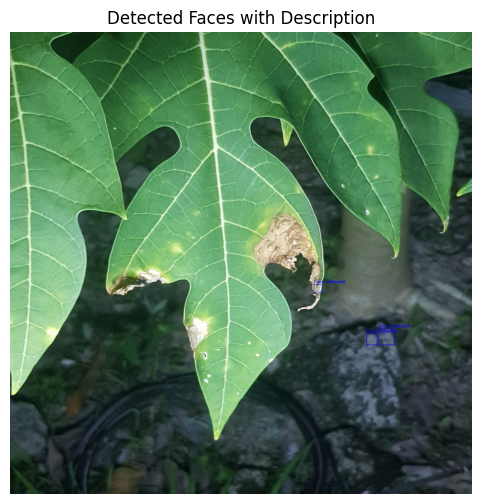

In [3]:
import cv2
import numpy as np
import requests

# Download the image from Firebase
response = requests.get(file_url)
if response.status_code == 200:
    image_array = np.asarray(bytearray(response.content), dtype=np.uint8)
    image = cv2.imdecode(image_array, cv2.IMREAD_COLOR)
else:
    raise RuntimeError(f"Failed to download the image from Firebase. Status code: {response.status_code}")

# Load the Haar cascade for face detection
haar_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Convert the image to grayscale for face detection
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Detect faces in the image
faces = haar_cascade.detectMultiScale(gray_image, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

# Draw rectangles around detected faces and add a description
for (x, y, w, h) in faces:
    cv2.rectangle(image, (x, y), (x + w, y + h), (255, 0, 0), 2)
    cv2.putText(image, "Face Detected", (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)

# Display the image with detected faces and description
import matplotlib.pyplot as plt

# Convert the image from BGR to RGB for displaying
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 6))
plt.imshow(image_rgb)
plt.axis('off')
plt.title("Detected Faces with Description")
plt.show()


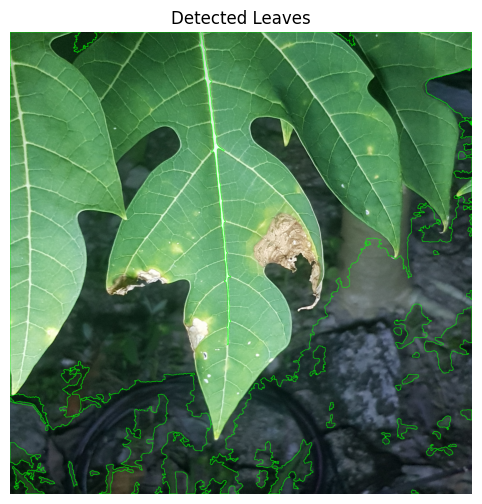

In [4]:
# Ensure the image is defined by downloading it again
response = requests.get(file_url)
if response.status_code == 200:
    image_array = np.asarray(bytearray(response.content), dtype=np.uint8)
    image = cv2.imdecode(image_array, cv2.IMREAD_COLOR)
else:
    raise RuntimeError(f"Failed to download the image from Firebase. Status code: {response.status_code}")

# Convert the image to HSV color space for better color segmentation
hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

# Define the range for green color in HSV
lower_green = np.array([40, 40, 40])  # Adjust these values as needed
upper_green = np.array([85, 255, 255])

# Create a mask for green color
mask = cv2.inRange(hsv_image, lower_green, upper_green)

# Perform morphological operations to remove noise
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)

# Find contours in the mask
contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Draw contours on the original image
leaf_image = image.copy()
for contour in contours:
    if cv2.contourArea(contour) > 500:  # Filter small contours
        cv2.drawContours(leaf_image, [contour], -1, (0, 255, 0), 2)

# Display the image with detected leaves
leaf_image_rgb = cv2.cvtColor(leaf_image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 6))
plt.imshow(leaf_image_rgb)
plt.axis('off')
plt.title("Detected Leaves")
plt.show()

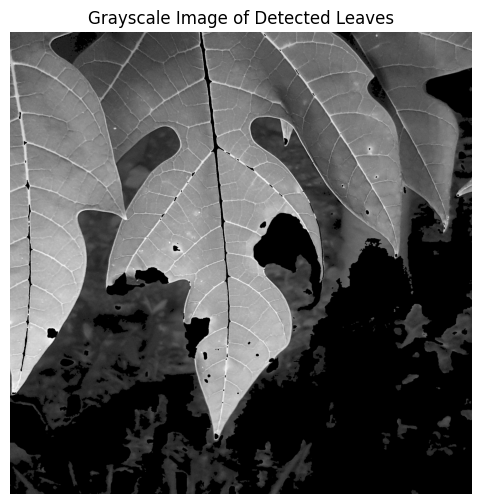

In [5]:
# Apply the mask to the grayscale image to isolate the detected leaves
leaf_gray_image = cv2.bitwise_and(gray_image, gray_image, mask=mask)

# Display the grayscale image of the detected leaves
plt.figure(figsize=(10, 6))
plt.imshow(leaf_gray_image, cmap='gray')
plt.axis('off')
plt.title("Grayscale Image of Detected Leaves")
plt.show()

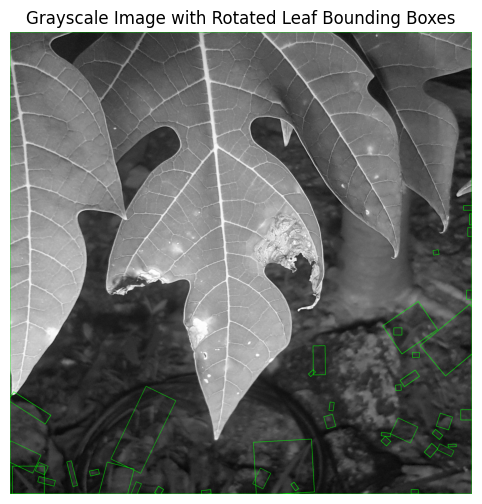

In [6]:
# Find minimum area rectangles for the detected leaves
leaf_rotated_boxes = []
for contour in contours:
    if cv2.contourArea(contour) > 500:
        rect = cv2.minAreaRect(contour)
        box = cv2.boxPoints(rect)
        box = box.astype(int)
        leaf_rotated_boxes.append(box)

# Draw rotated rectangles on a copy of the grayscale image
leafs_with_rotated_boxes = cv2.cvtColor(gray_image, cv2.COLOR_GRAY2BGR)
for box in leaf_rotated_boxes:
    cv2.drawContours(leafs_with_rotated_boxes, [box], 0, (0, 255, 0), 2)

plt.figure(figsize=(10, 6))
plt.imshow(cv2.cvtColor(leafs_with_rotated_boxes, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title("Grayscale Image with Rotated Leaf Bounding Boxes")
plt.show()

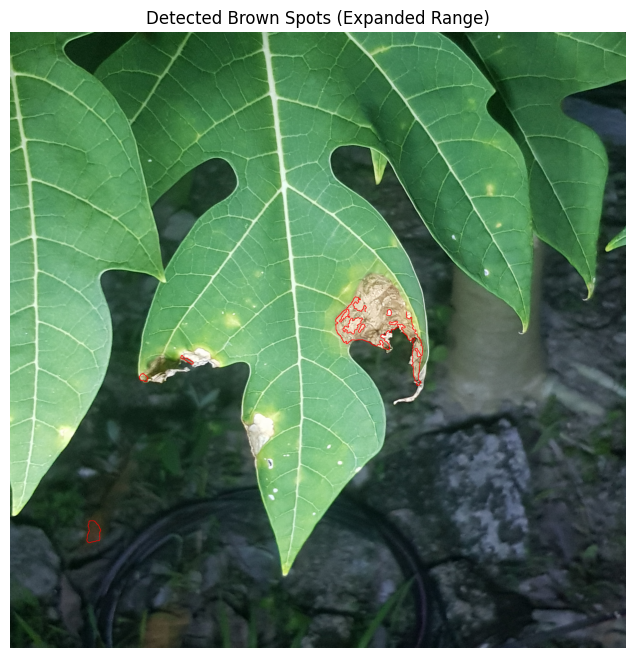

In [8]:
# Define the range for brown color in HSV (expanded range for better sensitivity)
lower_brown = np.array([8, 40, 20])  # Lower thresholds expanded
upper_brown = np.array([25, 255, 220])  # Upper thresholds expanded

# Create a mask for brown color
brown_mask = cv2.inRange(hsv_image, lower_brown, upper_brown)

# Perform morphological operations to remove noise
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7))  # Larger kernel for better noise removal
brown_mask = cv2.morphologyEx(brown_mask, cv2.MORPH_CLOSE, kernel)
brown_mask = cv2.morphologyEx(brown_mask, cv2.MORPH_OPEN, kernel)

# Find contours in the brown mask
brown_contours, _ = cv2.findContours(brown_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Draw contours on the original image
brown_image = image.copy()
# Apply edge detection using Canny
edges = cv2.Canny(brown_mask, 50, 150)

# Find contours in the edge-detected image
edge_contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Draw contours on the original image
for contour in edge_contours:
    if cv2.contourArea(contour) > 300:  # Filter small contours
        cv2.drawContours(brown_image, [contour], -1, (0, 0, 255), 2)

# Display the image with detected brown spots
brown_image_rgb = cv2.cvtColor(brown_image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12, 8))
plt.imshow(brown_image_rgb)
plt.axis('off')
plt.title("Detected Brown Spots (Expanded Range)")
plt.show()


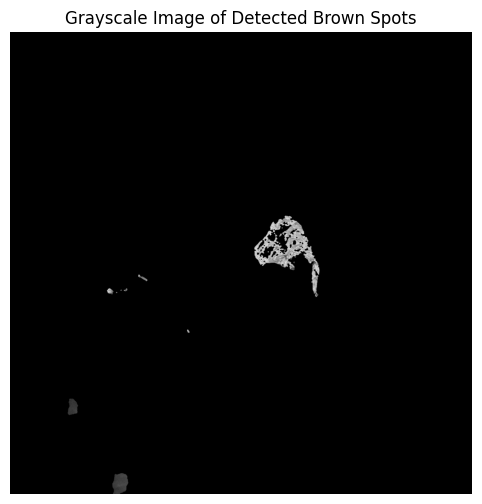

In [9]:
# Apply the brown mask to the grayscale image to isolate the detected brown spots
brown_spots_gray_image = cv2.bitwise_and(gray_image, gray_image, mask=brown_mask)

# Display the grayscale image of the detected brown spots
plt.figure(figsize=(10, 6))
plt.imshow(brown_spots_gray_image, cmap='gray')
plt.axis('off')
plt.title("Grayscale Image of Detected Brown Spots")
plt.show()

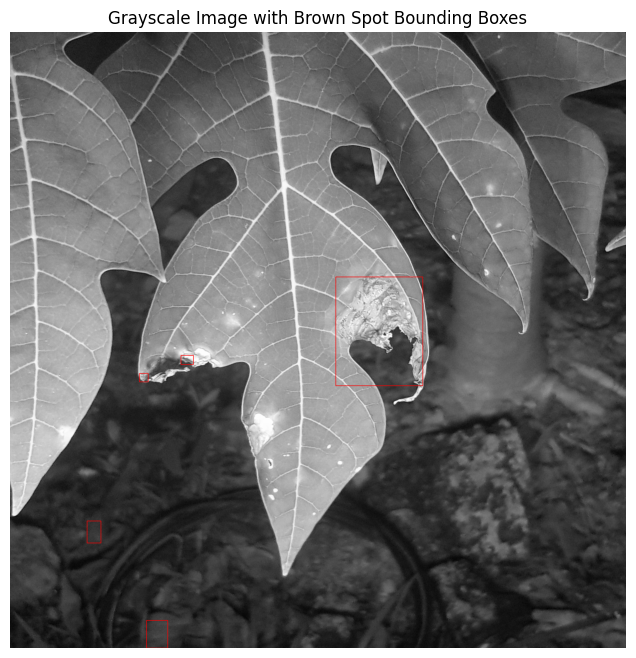

In [10]:
# Draw bounding boxes around brown spots on the grayscale image

brown_boxes_image = cv2.cvtColor(gray_image, cv2.COLOR_GRAY2BGR)

for contour in brown_contours:
    x, y, w, h = cv2.boundingRect(contour)
    if cv2.contourArea(contour) > 300:  # Filter small contours (same as before)
        cv2.rectangle(brown_boxes_image, (x, y), (x + w, y + h), (0, 0, 255), 2)

plt.figure(figsize=(12, 8))
plt.imshow(cv2.cvtColor(brown_boxes_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title("Grayscale Image with Brown Spot Bounding Boxes")
plt.show()

In [11]:
# Calculate the percentage of brown spots relative to green leaves

# Count non-zero pixels in the masks
green_pixels = np.count_nonzero(mask)
brown_pixels = np.count_nonzero(brown_mask)

if green_pixels > 0:
    brown_percentage = (brown_pixels / green_pixels) * 100
    print(f"Brown spots cover {brown_percentage:.2f}% of the green leaf area.")
else:
    print("No green leaf area detected in the image.")

Brown spots cover 1.37% of the green leaf area.


In [15]:
# Ensure timestamp is defined
if 'timestamp' not in globals():
    import datetime
    timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M")

# Ensure filename is defined
if 'filename' not in globals():
    filename = f"photo_{timestamp}.jpg"

# Initialize Firebase Database
db = firebase.database()

# Prepare the data to send
brown_spots_data = {
    "timestamp": timestamp,
    "filename": filename,
    "brown_percentage": brown_percentage
}

# Send the data to Firebase Realtime Database
db.child("brown_spots_percentage").push(brown_spots_data)

print("Brown spots percentage uploaded to Firebase.")

Brown spots percentage uploaded to Firebase.


In [ ]:
from tensorflow import keras
import cv2
import numpy as np

# Load the trained .keras model
model = keras.models.load_model("<PATH_TO_YOUR_MODEL>.keras")

# Preprocess the image (resize, normalize, etc.)
input_size = (256, 256)  # Change to your model's expected input size
leaf_img_resized = cv2.resize(image, input_size)
leaf_img_rgb = cv2.cvtColor(leaf_img_resized, cv2.COLOR_BGR2RGB)
leaf_img_norm = leaf_img_rgb / 255.0  # Normalize to [0, 1]
input_tensor = np.expand_dims(leaf_img_norm, axis=0)  # Add batch dimension

# Do NOT flatten the input, keep shape (1, 256, 256, 3)
predictions = model.predict(input_tensor)
predicted_class = np.argmax(predictions, axis=1)[0]

# If you have class names
class_names = [
	'Bacterial_spot',
	'Early_blight',
	'Late_blight',
	'Leaf_Mold',
	'Septoria_leaf_spot',
	'Spider_mites Two-spotted_spider_mite',
	'Target_Spot',
	'Tomato_Yellow_Leaf_Curl_Virus',
	'Tomato_mosaic_virus',
	'healthy'
]  # Replace with your actual class names
print(f"Predicted leaf condition: {class_names[predicted_class]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted leaf condition: Late_blight


In [17]:
# Your Firebase Web Config from environment variables
config = {
	"apiKey": os.getenv("FIREBASE_API_KEY"),
	"authDomain": os.getenv("FIREBASE_AUTH_DOMAIN"),
	"projectId": os.getenv("FIREBASE_PROJECT_ID"),
	"storageBucket": os.getenv("FIREBASE_STORAGE_BUCKET"),
	"messagingSenderId": os.getenv("FIREBASE_MESSAGING_SENDER_ID"),
	"appId": os.getenv("FIREBASE_APP_ID"),
	"databaseURL": os.getenv("FIREBASE_DATABASE_URL")
}
# Initialize Firebase Database
db = firebase.database()

# Prepare the data to send
data = {
	"timestamp": timestamp,
	"filename": filename,
	"predicted_condition": class_names[predicted_class]
}

# Send the data to Firebase Realtime Database
db.child("leaf_conditions").push(data)

print("Predicted leaf condition sent to Firebase.")

Predicted leaf condition sent to Firebase.


Labeled photo saved locally at G:\My Drive\University Files\4th Semester\Machine Learning\Final Project\Firebase Upload\photos\photo_2025-06-03_22-25_brown_labeled.jpg
Labeled photo uploaded to Firebase Storage at photos/photo_2025-06-03_22-25_brown_labeled.jpg


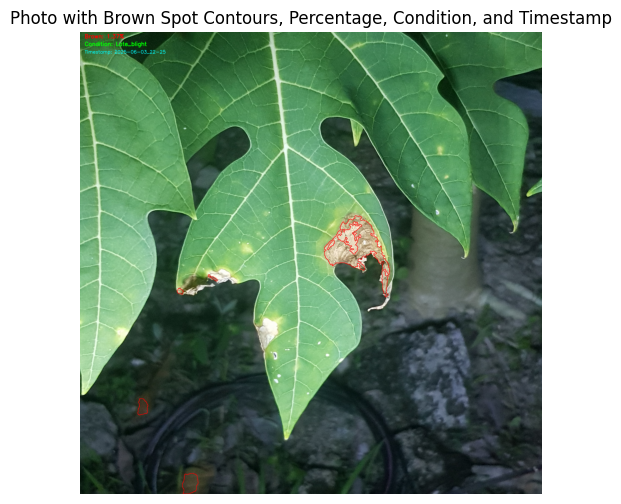

In [22]:
# Copy the original image to avoid modifying it in-place
photo_with_brown = image.copy()

# Draw brown spot contours
for contour in brown_contours:
    if cv2.contourArea(contour) > 300:
        cv2.drawContours(photo_with_brown, [contour], -1, (0, 0, 255), 2)

# Draw the brown percentage as text
brown_text = f"Brown: {brown_percentage:.2f}%"
cv2.putText(
    photo_with_brown, brown_text, (30, 40),
    cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 0, 255), 3
)

# Draw the predicted leaf condition as text
condition_text = f"Condition: {class_names[predicted_class]}"
cv2.putText(
    photo_with_brown, condition_text, (30, 90),
    cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 255, 0), 3
)

# Draw the timestamp as text
cv2.putText(
    photo_with_brown, f"Timestamp: {timestamp}", (30, 140),
    cv2.FONT_HERSHEY_SIMPLEX, 1.0, (255, 255, 0), 2
)

# Save and upload the labeled photo
labeled_photo_filename = filename.replace('.jpg', '_brown_labeled.jpg')
labeled_photo_filepath = os.path.join(save_folder, labeled_photo_filename)
labeled_photo_firebase_path = f"photos/{labeled_photo_filename}"

cv2.imwrite(labeled_photo_filepath, photo_with_brown)
print(f"Labeled photo saved locally at {labeled_photo_filepath}")

storage.child(labeled_photo_firebase_path).put(labeled_photo_filepath)
print(f"Labeled photo uploaded to Firebase Storage at {labeled_photo_firebase_path}")

# Optionally, display the result
plt.figure(figsize=(10, 6))
plt.imshow(cv2.cvtColor(photo_with_brown, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title("Photo with Brown Spot Contours, Percentage, Condition, and Timestamp")
plt.show()

In [23]:
# Prepare the data for the labeled photo
labeled_photo_data = {
    "timestamp": timestamp,
    "filename": labeled_photo_filename,
    "labeled_photo_url": storage.child(labeled_photo_firebase_path).get_url(None)
}

# Upload the labeled photo link to Firebase Realtime Database
db.child("labeled_photos").push(labeled_photo_data)

print("Labeled photo link uploaded to Firebase Realtime Database.")

Labeled photo link uploaded to Firebase Realtime Database.
